## Import packages and setup paths

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import platform
import sys

# Add nat_zacros package to path (located in ../nat_zacros relative to this notebook)
project_root = Path.cwd().parent  # Goes from O_Pt111 to GIT
nat_zacros_pkg_dir = project_root / 'nat_zacros'
if nat_zacros_pkg_dir.exists() and str(nat_zacros_pkg_dir) not in sys.path:
    sys.path.insert(0, str(nat_zacros_pkg_dir))
    print(f"Added to path: {nat_zacros_pkg_dir}")

from nat_zacros import lattice, state, trajectory, load_trajectories_parallel
from nat_zacros import compute_rdf_parallel, compute_rdf_parallel_states
import pickle
import multiprocessing as mp
import time



# Check available processors
n_cores = mp.cpu_count()
print(f"Available logical processors: {n_cores}")

# Dictionary mapping usernames to data paths
user_paths = {
    'a-DJA'  : Path('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations'),
    'akandra': Path('/home/akandra/O_Pt111/zacros_calculations'),
}

if platform.system() == 'Windows':
    username = os.getenv('USERNAME')
else:  # Linux/Mac
    username = os.getenv('USER')

# Get path for current user
if username in user_paths:
    dir_with_calculations = user_paths[username]
else:
    raise ValueError(f"Unknown user: {username}. Please add your username and path to user_paths dictionary.")

print(f"Operating System: {platform.system()}")
print(f"User            : {username}")
print(f"Data directory  : {dir_with_calculations.as_posix()}")

Added to path: c:\Users\a-DJA\GIT\nat_zacros
Available logical processors: 14
Operating System: Windows
User            : a-DJA
Data directory  : c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations


## Load job information from fn_3leed

In [2]:
# Set directories
log_dir = dir_with_calculations / 'fn_3leed'
data_dir = log_dir / 'jobs'
results_dir = log_dir / 'results'
log_file = data_dir / 'jobs.log'

# Verify the file exists
if not log_file.exists():
    raise FileNotFoundError(f"Log file not found: {log_file}")

# Load json log file
with open(log_file, 'r') as f:
    log_header = f.readline().split()  # Read header
    log_entries = [json.loads(line) for line in f if line.strip()]

Path.mkdir(results_dir, exist_ok=True)

# Parse job information
run_dirs = [data_dir / str(entry[0]) for entry in log_entries]
temperatures = [entry[4] for entry in log_entries]
lat_size = [entry[2][0]*entry[2][1] for entry in log_entries]
n_ads = [entry[3][0] for entry in log_entries]
interactions = ['-'.join(entry[5][1:]) for entry in log_entries]
coverages = [n_ads[i]/lat_size[i] for i in range(len(n_ads))]

print(f"Found {len(run_dirs)} simulation runs")
print(f"First run: {run_dirs[0].name}")
print(f"  Temperature: {temperatures[0]} K")
print(f"  Coverage: {coverages[0]:.3f} ML")
print(f"  Interactions: {interactions[0]}")

Found 19 simulation runs
First run: 1
  Temperature: 50 K
  Coverage: 0.110 ML
  Interactions: 1nn-2nn-3nn-4nn-5nn-6nn-7nn-8nn-9nn-1-1-1-1-1-2-1-1-3-2-2-5-2-2-6-3-3-3-1-2-3


## Test trajectory class on first run

In [3]:
# Select first run as test case
rundir = run_dirs[0]
print(f"Testing with: {rundir}")

# Find all trajectory directories
traj_dirs = sorted([d for d in rundir.iterdir() if d.is_dir() and d.name.startswith('traj_')])
print(f"Found {len(traj_dirs)} trajectories")

# Test with first trajectory
if len(traj_dirs) > 0:
    test_traj_dir = traj_dirs[0]
    print(f"\nLoading trajectory from: {test_traj_dir.name}")
    
    # Create lattice
    lat = lattice(test_traj_dir)
    print(f"Lattice: {repr(lat)}")
    
    # Create trajectory and load states
    traj = trajectory(lat, test_traj_dir)
    traj.load_trajectory()
    print(f"\nTrajectory: {repr(traj)}")
    print(f"Loaded {len(traj)} states")
    
    if len(traj) > 0:
        print(f"\nFirst state: {repr(traj[0])}")
        print(f"Last state:  {repr(traj[-1])}")
else:
    print("No trajectory directories found!")

Testing with: c:\Users\a-DJA\Dropbox\Surface_Reaction_Kinetics\O_Pt111\zacros_calculations\fn_3leed\jobs\1
Found 10 trajectories

Loading trajectory from: traj_1
Lattice: lattice(type='periodic_cell', size=(np.int64(40), np.int64(40)), nsites=1600, area=11028.04)

Trajectory: trajectory(nstates=200, t=[0.00, 562984394862342710615165585354467049472.00], lattice=1600 sites)
Loaded 200 states

First state: state(nsites=1600, n_adsorbates=176, coverage=0.110)
Last state:  state(nsites=1600, n_adsorbates=176, coverage=0.110)


## Plot energy vs time for first run
This reproduces cell 58 from zacros_analyze.ipynb for the first case

In [4]:
# --------------------------------------------------------------------------
# ------        Load all trajectories using trajectory class          ------
# --------------------------------------------------------------------------

rundir = run_dirs[0]  # First run

# Get list of trajectory directories
traj_dirs = sorted([d for d in rundir.iterdir() if d.is_dir() and d.name.startswith('traj_')])

if len(traj_dirs) == 0:
    print("No trajectory directories found!")
    trajs = []
else:
    print(f"Loading {len(traj_dirs)} trajectories (energy only mode)...")
    
    # Create lattice (same for all trajectories in this run)
    lat = lattice(traj_dirs[0])
    
    # Load all trajectories with energy_only=True for fast loading
    # This skips parsing full state configurations and only extracts time/energy
    trajs = []
    for traj_dir in traj_dirs:
        traj = trajectory(lat, traj_dir)
        traj.load_trajectory(load_energy=True, energy_only=True)
        trajs.append(traj)
    
    print(f"Successfully loaded {len(trajs)} trajectories")
    print(f"Example: {repr(trajs[0])}")
    print(f"States in trajectory: {len(trajs[0].times)} time/energy points")

Loading 10 trajectories (energy only mode)...
Successfully loaded 10 trajectories
Example: trajectory(nstates=200, t=[0.00, 562984394862342710615165585354467049472.00], lattice=1600 sites)
States in trajectory: 200 time/energy points


## Bin and average energy across trajectories

In [5]:
# --------------------------------------------------------------------------
# ------        Bin energy data for plotting                          ------
# --------------------------------------------------------------------------

n_time_bins = 100

# Determine common time range
end_time = min([traj.times[-1] for traj in trajs])
print(f"Common time range: 0 to {end_time:.2e} s")

# Create time bins
time_bins = np.linspace(0, end_time, n_time_bins + 1)
time_bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
energy_hist = np.zeros(n_time_bins)

# Accumulate energy from all trajectories
for traj in trajs:
    times, energies = traj.get_energy_vs_time()
    
    # Bin the energy values
    for t, energy in zip(times, energies):
        if t <= end_time:
            bin_index = np.digitize(t, time_bins, right=False) - 1
            if 0 <= bin_index < n_time_bins:
                energy_hist[bin_index] += energy

# Average over trajectories
energy_hist /= len(trajs)

print(f"Binned energy data from {len(trajs)} trajectories")


Common time range: 0 to 4.69e+38 s
Binned energy data from 10 trajectories


## Plot energy vs time
This reproduces cell 58 from zacros_analyze.ipynb for the first case

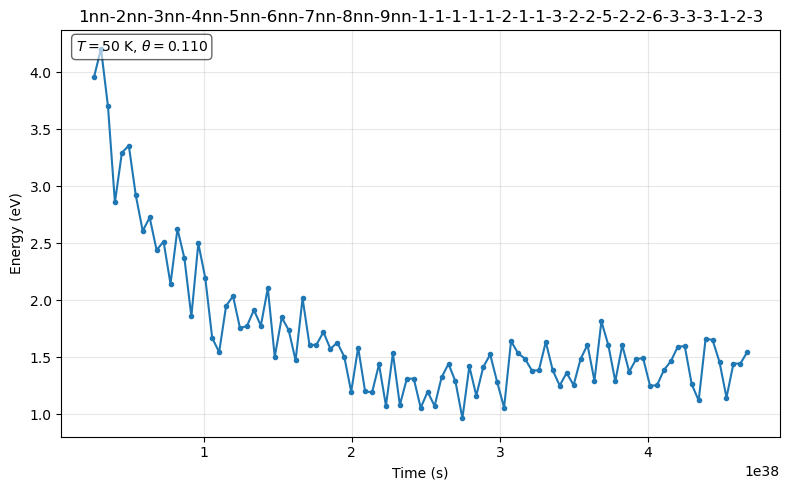


Energy statistics (after 50% equilibration):
  Mean:   1.3913 eV
  Std:    0.1828 eV
  Min:    0.9664 eV
  Max:    1.8168 eV


In [6]:
# --------------------------------------------------------------------------
# ------        Plot energy vs time                                   ------
# --------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 5))

# Skip first few bins (may be initialization artifacts)
skip_bins = 5

ax.plot(time_bin_centers[skip_bins:], energy_hist[skip_bins:], 
        marker='o', linestyle='-', markersize=3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Energy (eV)')
ax.set_title(f'{interactions[0]}')
ax.text(0.02, 0.98, fr'$T={temperatures[0]}$ K, $\theta={coverages[0]:.3f}$',
        transform=ax.transAxes,
        va='top', ha='left',
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimate equilibration point
eq_fraction = 0.5
eq_bin = int(eq_fraction * n_time_bins)

print(f"\nEnergy statistics (after {eq_fraction*100:.0f}% equilibration):")
print(f"  Mean:   {np.mean(energy_hist[eq_bin:]):.4f} eV")
print(f"  Std:    {np.std(energy_hist[eq_bin:]):.4f} eV")
print(f"  Min:    {np.min(energy_hist[eq_bin:]):.4f} eV")
print(f"  Max:    {np.max(energy_hist[eq_bin:]):.4f} eV")

In [8]:
# --------------------------------------------------------------------------
# ------        Print binned energy data                              ------
# --------------------------------------------------------------------------
# print("\nBinned energy data (time (s), energy (eV)):")
for t, e in zip(time_bin_centers, energy_hist):
    print(f"{t:.6e}  {e:.6e}")


2.347202e+36  2.997455e+01
7.041605e+36  7.721509e+00
1.173601e+37  5.645799e+00
1.643041e+37  5.395128e+00
2.112481e+37  4.353494e+00
2.581922e+37  3.960992e+00
3.051362e+37  4.207477e+00
3.520802e+37  3.703202e+00
3.990243e+37  2.860141e+00
4.459683e+37  3.294577e+00
4.929123e+37  3.359008e+00
5.398564e+37  2.923928e+00
5.868004e+37  2.609466e+00
6.337444e+37  2.727799e+00
6.806885e+37  2.441682e+00
7.276325e+37  2.516894e+00
7.745765e+37  2.144356e+00
8.215205e+37  2.627728e+00
8.684646e+37  2.369483e+00
9.154086e+37  1.859360e+00
9.623526e+37  2.501066e+00
1.009297e+38  2.197221e+00
1.056241e+38  1.670276e+00
1.103185e+38  1.546178e+00
1.150129e+38  1.952908e+00
1.197073e+38  2.036740e+00
1.244017e+38  1.756586e+00
1.290961e+38  1.776257e+00
1.337905e+38  1.915451e+00
1.384849e+38  1.778762e+00
1.431793e+38  2.106975e+00
1.478737e+38  1.504566e+00
1.525681e+38  1.850250e+00
1.572625e+38  1.740919e+00
1.619569e+38  1.473895e+00
1.666513e+38  2.019303e+00
1.713457e+38  1.608165e+00
1

## Test equilibration methods

-- no longer applicable -- get_equilibtrated_slice was eliminated in nat-zarcos

In [7]:
# --------------------------------------------------------------------------
# ------        Test equilibrated slice functionality                 ------
# --------------------------------------------------------------------------

# Take first trajectory as example
traj_test = trajs[0]

print(f"Original trajectory: {len(traj_test)} states")

# Get equilibrated slice
traj_eq = traj_test.get_equilibrated_slice(fraction=0.5)
print(f"Equilibrated trajectory: {len(traj_eq)} states")

# Compare energy statistics
times_full, energies_full = traj_test.get_energy_vs_time()
times_eq, energies_eq = traj_eq.get_energy_vs_time()

print(f"\nFull trajectory energy:")
print(f"  Mean: {np.mean(energies_full):.4f} eV")
print(f"  Std:  {np.std(energies_full):.4f} eV")

print(f"\nEquilibrated trajectory energy:")
print(f"  Mean: {np.mean(energies_eq):.4f} eV")
print(f"  Std:  {np.std(energies_eq):.4f} eV")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Full trajectory
axes[0].plot(times_full, energies_full, 'b-', alpha=0.6, linewidth=0.5)
axes[0].axhline(np.mean(energies_full), color='r', linestyle='--', label='Mean')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Energy (eV)')
axes[0].set_title('Full trajectory')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Equilibrated only
axes[1].plot(times_eq, energies_eq, 'g-', alpha=0.6, linewidth=0.5)
axes[1].axhline(np.mean(energies_eq), color='r', linestyle='--', label='Mean')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Energy (eV)')
axes[1].set_title('Equilibrated (50% cutoff)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Original trajectory: 200 states


AttributeError: 'trajectory' object has no attribute 'get_equilibrated_slice'

## RDF Analysis
Compute radial distribution function averaged over all trajectories

### Quick RDF test with 2 trajectories

In [8]:
# RDF parameters
lattice_constant = 2.821135  # 1nn distance in Angstroms (Pt(111))
r_max = 40.0  # Angstrom
dr = 0.1  # Bin width

print("Computing reference RDF (g_ref) for full lattice...")
r_ref, g_ref = trajs[0].get_g_ref(r_max=r_max, dr=dr)

# Use only first 2 trajectories for quick testing
test_trajs = trajs[:2]
print(f"\nQuick test: Loading equilibrated states for {len(test_trajs)} trajectories...")

# Start timing
t_start = time.time()

# Reload each trajectory with full state data for equilibrated portion
for i, traj in enumerate(test_trajs):
    traj.load_equilibrated_states(fraction=0.5)

print(f"\nComputing RDF for each trajectory (sequential)...")

# Compute RDF for each trajectory
rdfs_test = []
for i, traj in enumerate(test_trajs):
    r, g = traj.get_rdf(r_max=r_max, dr=dr, g_ref=g_ref)
    rdfs_test.append(g)

# Average RDFs
g_avg_test = np.mean(rdfs_test, axis=0)
g_std_test = np.std(rdfs_test, axis=0)

# Convert to a_0 units
r_a0 = r / lattice_constant

t_elapsed = time.time() - t_start

print(f"\nQuick test completed in {t_elapsed:.2f} seconds")
print(f"  Averaged over {len(test_trajs)} trajectories")


Computing reference RDF (g_ref) for full lattice...

Quick test: Loading equilibrated states for 2 trajectories...

Computing RDF for each trajectory (sequential)...

Quick test completed in 7.85 seconds
  Averaged over 2 trajectories


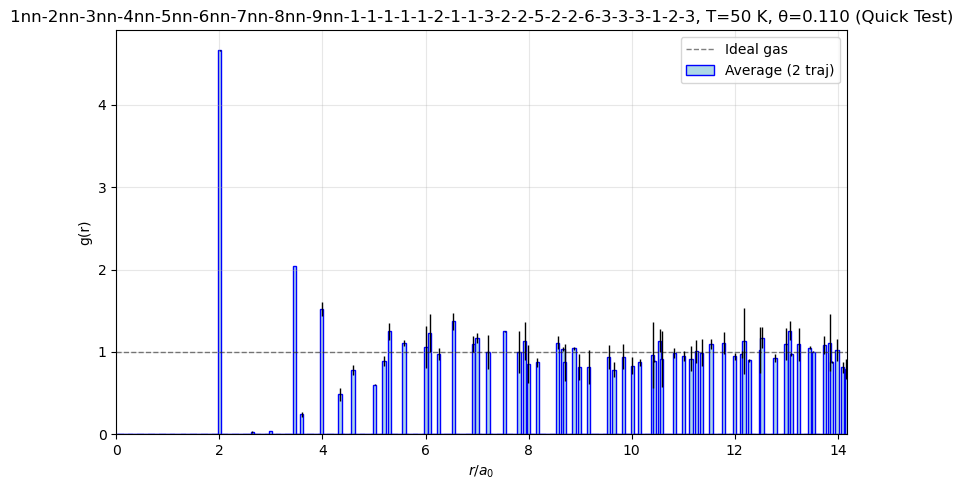

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate proper bar width based on bin spacing in a_0 units
bar_width = (dr / lattice_constant) * 1.8  # 180% of bin width

ax.bar(r_a0, g_avg_test, width=bar_width, ec='blue', fc='lightblue', 
       label=f'Average ({len(test_trajs)} traj)', align='center')
ax.errorbar(r_a0, g_avg_test, yerr=g_std_test, fmt='none', ecolor='black', 
            capsize=0, linewidth=1, zorder=10)
ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal gas')
ax.set_xlabel(r'$r / a_0$')
ax.set_ylabel('g(r)')
ax.set_title(f'{interactions[0]}, T={temperatures[0]} K, θ={coverages[0]:.3f} (Quick Test)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, r_max/lattice_constant)
plt.tight_layout()
plt.show()

### Full RDF computation (all 10 trajectories) - Sequential

### Optimization Strategies for Loading Time

**Current bottleneck:** 64s loading vs 2s computation

**Three strategies to improve loading:**

1. **Parallel Loading** (5-10x speedup, easy)
   - Load multiple trajectories simultaneously
   - Each trajectory reads its own file → perfect for parallelism
   - Use `load_trajectories_parallel()` function

2. **Binary Caching** (10-100x speedup on re-runs, medium effort)
   - Save parsed states to HDF5/pickle after first load
   - Subsequent loads read binary instead of parsing text
   - Best for repeated analysis of same data

3. **Optimized Parser** (2-3x speedup, hard)
   - Use Cython or compiled parsers
   - Vectorize string operations
   - More complex implementation

**Demo below shows parallel loading:**

In [10]:
# Clear existing trajectories to force reload
trajs = []

print("=" * 70)
print("LOADING PERFORMANCE COMPARISON")
print("=" * 70)

# Test 1: Sequential loading (current method)
print("\nTest 1: Sequential loading (current method)")
print("-" * 70)
t_start = time.time()

trajs_seq = []
for i, traj_dir in enumerate(traj_dirs):
    traj = trajectory(lat, traj_dir)
    traj.load_trajectory(load_energy=True, energy_only=True)
    traj.load_equilibrated_states(fraction=0.5)
    trajs_seq.append(traj)
    print(f"  Loaded trajectory {i+1}/{len(traj_dirs)}...", end='\r')

t_sequential = time.time() - t_start
print(f"\n✓ Sequential loading: {t_sequential:.2f} seconds")

# Test 2: Parallel loading (NEW)
print("\nTest 2: Parallel loading (NEW)")
print("-" * 70)
t_start = time.time()

trajs_par = load_trajectories_parallel(lat, traj_dirs, fraction=0.5, n_workers=None)

t_parallel = time.time() - t_start
print(f"✓ Parallel loading: {t_parallel:.2f} seconds")

# Results
print("\n" + "=" * 70)
print("RESULTS")
print("=" * 70)
print(f"Sequential loading: {t_sequential:.2f} s")
print(f"Parallel loading:   {t_parallel:.2f} s")
print(f"Speedup:            {t_sequential/t_parallel:.1f}x")
print(f"Efficiency:         {(t_sequential/t_parallel)/mp.cpu_count()*100:.0f}% of ideal")
print("=" * 70)

# Verify results are identical
print(f"\nVerification: {len(trajs_seq)} vs {len(trajs_par)} trajectories loaded")
print(f"States per trajectory: {len(trajs_seq[0])} vs {len(trajs_par[0])}")

# Use parallel-loaded trajectories for rest of analysis
trajs = trajs_par

LOADING PERFORMANCE COMPARISON

Test 1: Sequential loading (current method)
----------------------------------------------------------------------
  Loaded trajectory 10/10...
✓ Sequential loading: 37.13 seconds

Test 2: Parallel loading (NEW)
----------------------------------------------------------------------
Loading 10 trajectories in parallel using 14 workers...


Loading trajectories: 100%|██████████| 10/10 [00:11<00:00,  1.17s/traj]

Successfully loaded 10 trajectories
  Example: 100 states per trajectory (equilibrated)
✓ Parallel loading: 12.18 seconds

RESULTS
Sequential loading: 37.13 s
Parallel loading:   12.18 s
Speedup:            3.1x
Efficiency:         22% of ideal

Verification: 10 vs 10 trajectories loaded
States per trajectory: 100 vs 100


### Further Optimization: Binary Caching

For **even faster repeated analysis**, save parsed trajectories to binary format:

```python
# Example implementation (not included yet):
import pickle

# First time: load and cache
cache_file = results_dir / f'{rundir.name}_trajs_eq.pkl'
if not cache_file.exists():
    trajs = load_trajectories_parallel(lat, traj_dirs, fraction=0.5)
    with open(cache_file, 'wb') as f:
        pickle.dump(trajs, f)
else:
    # Subsequent runs: load from cache (~0.5s instead of 64s)
    with open(cache_file, 'rb') as f:
        trajs = pickle.load(f)
```

**Performance comparison:**
- **Text parsing**: 64s sequential, ~6-10s parallel
- **Binary loading**: ~0.5-1s (100x faster!)
- **Trade-off**: Disk space (~50-200 MB per cached run)

**When to use:**
- Repeated analysis of same trajectories with different parameters
- Exploring different RDF settings, cluster sizes, etc.
- Not needed if running once and moving on

In [11]:
traj_dirs

[WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_1'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_10'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_2'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_3'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_4'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_5'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_6'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations/fn_3leed/jobs/1/traj_7'),
 WindowsPath('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/

In [12]:
# RDF parameters (reuse from quick test if already defined)
# locals() returns a dict of all variables in the current namespace
# This checks if 'lattice_constant' already exists to avoid recomputing g_ref
# (useful when re-running this cell without re-running earlier cells)
if 'lattice_constant' not in locals():
    lattice_constant = 2.821135  # 1nn distance in Angstroms (Pt(111))
    r_max = 40.0  # Angstrom
    dr = 0.1  # Bin width
    print(f"Computing reference RDF (g_ref) for full lattice...")
    r_ref, g_ref = trajs[0].get_g_ref(r_max=r_max, dr=dr)

print(f"\nLoading equilibrated states for {len(trajs)} trajectories...")

# Time loading
t_load_start = time.time()

# # Reload each trajectory with full state data for equilibrated portion
# for i, traj in enumerate(trajs):
#     print(f"  Loading trajectory {i+1}/{len(trajs)}...", end='\r')
#     traj.load_equilibrated_states(fraction=0.5)


# First time: load and cache
cache_file = results_dir / f'{rundir.name}_trajs_eq.pkl'
if not cache_file.exists():
    trajs = load_trajectories_parallel(lat, traj_dirs, fraction=0.5)
    with open(cache_file, 'wb') as f:
        pickle.dump(trajs, f)
else:
    # Subsequent runs: load from cache (~0.5s instead of 64s)
    with open(cache_file, 'rb') as f:
        trajs = pickle.load(f)


t_load = time.time() - t_load_start

print(f"\nComputing RDF for each trajectory (sequential)...")

# Time RDF computation
t_compute_start = time.time()

# Compute RDF for each trajectory (sequential)
rdfs = []
for i, traj in enumerate(trajs):
    print(f"  Computing RDF {i+1}/{len(trajs)}...", end='\r')
    r, g = traj.get_rdf(r_max=r_max, dr=dr, g_ref=g_ref)
    rdfs.append(g)

t_compute = time.time() - t_compute_start

# Average RDFs across all trajectories
g_avg = np.mean(rdfs, axis=0)
g_std = np.std(rdfs, axis=0)

# Convert distance to units of a_0
r_a0_seq = r / lattice_constant

print(f"\n\nSequential computation completed:")
print(f"  Loading time:   {t_load:.2f} seconds")
print(f"  Computing time: {t_compute:.2f} seconds")
print(f"  Total time:     {t_load + t_compute:.2f} seconds")
print(f"  Averaged over {len(trajs)} trajectories")


Loading equilibrated states for 10 trajectories...

Computing RDF for each trajectory (sequential)...
  Computing RDF 10/10...

Sequential computation completed:
  Loading time:   0.10 seconds
  Computing time: 1.47 seconds
  Total time:     1.58 seconds
  Averaged over 10 trajectories


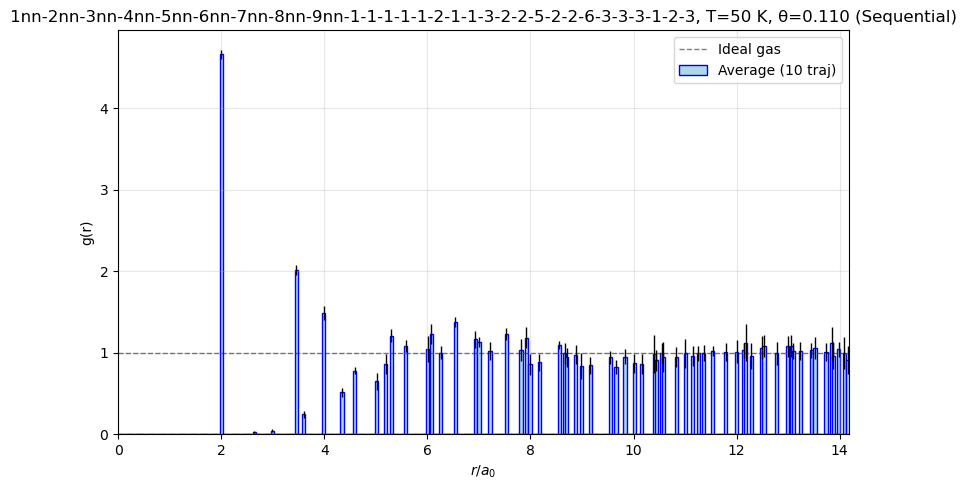

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate proper bar width based on bin spacing in a_0 units
bar_width = (dr / lattice_constant) * 1.8  # 180% of bin width

ax.bar(r_a0_seq, g_avg, width=bar_width, ec='blue', fc='lightblue', 
       label=f'Average ({len(trajs)} traj)', align='center')
ax.errorbar(r_a0_seq, g_avg, yerr=g_std, fmt='none', ecolor='black', 
            capsize=0, linewidth=1, zorder=10)
ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal gas')
ax.set_xlabel(r'$r / a_0$')
ax.set_ylabel('g(r)')
ax.set_title(f'{interactions[0]}, T={temperatures[0]} K, θ={coverages[0]:.3f} (Sequential)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, r_max/lattice_constant)
plt.tight_layout()
plt.show()

### Full RDF computation (all 10 trajectories) - Parallel

In [14]:

# Reload trajectories if states were cleared
if len(trajs[0].states) == 0:
    print(f"Reloading equilibrated states for {len(trajs)} trajectories...")
    for traj in trajs:
        traj.load_equilibrated_states(fraction=0.5)

print(f"\nComputing RDF using parallel processing...")

# Start timing
t_start = time.time()

# Parallel RDF computation - use all available cores (None = auto-detect)
r_parallel, g_avg_parallel, g_std_parallel = compute_rdf_parallel(
    trajs, r_max=r_max, dr=dr, g_ref=g_ref, n_workers=None
)

# Convert to a_0 units
r_a0_parallel = r_parallel / lattice_constant

t_elapsed = time.time() - t_start

print(f"\nParallel computation completed in {t_elapsed:.2f} seconds")
print(f"  Averaged over {len(trajs)} trajectories")
print(f"  First peak location: {r_a0_parallel[np.argmax(g_avg_parallel[:20])]:.2f} a_0")
print(f"  First peak height: {np.max(g_avg_parallel[:20]):.3f}")


Computing RDF using parallel processing...
Computing RDF for 10 trajectories using 14 workers...


Computing RDF: 100%|██████████| 10/10 [00:01<00:00,  8.05traj/s]



Successfully computed RDF averaged over 10 trajectories

Parallel computation completed in 1.68 seconds
  Averaged over 10 trajectories
  First peak location: 0.02 a_0
  First peak height: 0.000


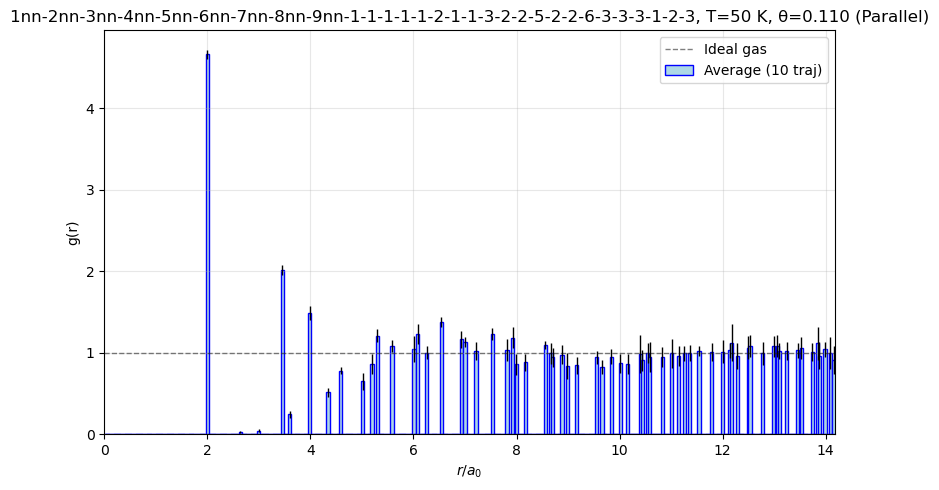

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate proper bar width based on bin spacing in a_0 units
bar_width = (dr / lattice_constant) * 1.8  # 180% of bin width

ax.bar(r_a0_parallel, g_avg_parallel, width=bar_width, ec='blue', fc='lightblue', 
       label=f'Average ({len(trajs)} traj)', align='center')
ax.errorbar(r_a0_parallel, g_avg_parallel, yerr=g_std_parallel, fmt='none', ecolor='black', 
            capsize=0, linewidth=1, zorder=10)
ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal gas')
ax.set_xlabel(r'$r / a_0$')
ax.set_ylabel('g(r)')
ax.set_title(f'{interactions[0]}, T={temperatures[0]} K, θ={coverages[0]:.3f} (Parallel)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, r_max/lattice_constant)
plt.tight_layout()
plt.show()

### Performance Comparison: State-level vs Trajectory-level Parallelism

In [16]:
from nat_zacros import compute_rdf_parallel_states
import time

# Reload trajectories if states were cleared
if len(trajs[0].states) == 0:
    print(f"Reloading equilibrated states for {len(trajs)} trajectories...")
    for traj in trajs:
        traj.load_equilibrated_states(fraction=0.5)

print(f"\n{'='*70}")
print("PERFORMANCE COMPARISON")
print(f"{'='*70}")
print(f"System: {len(trajs)} trajectories, ~{len(trajs[0].states)} states each")
print(f"Cores available: {mp.cpu_count()}")
print(f"\nBottleneck with trajectory-level parallelism:")
print(f"  - Only {len(trajs)} tasks for {mp.cpu_count()} cores → poor utilization")
print(f"  - Expected speedup: ~{min(len(trajs), mp.cpu_count()):.1f}x (you observed 2-3x)")
print(f"\nImprovement with state-level parallelism:")
print(f"  - Total tasks: {len(trajs) * len(trajs[0].states)} states")
print(f"  - All {mp.cpu_count()} cores can stay busy")
print(f"  - Expected speedup: ~{mp.cpu_count():.1f}x (near-linear)")
print(f"{'='*70}\n")

# Test 1: Trajectory-level parallel (original)
print("Test 1: Trajectory-level parallelism (original method)")
print("-" * 70)
t_start = time.time()
r1, g1_avg, g1_std = compute_rdf_parallel(
    trajs, r_max=r_max, dr=dr, g_ref=g_ref, n_workers=None
)
t_traj_parallel = time.time() - t_start
print(f"✓ Completed in {t_traj_parallel:.2f} seconds\n")

# Test 2: State-level parallel (NEW - better for few trajectories)
print("Test 2: State-level parallelism (NEW - better for your case)")
print("-" * 70)
t_start = time.time()
r2, g2_avg, g2_std = compute_rdf_parallel_states(
    trajs, r_max=r_max, dr=dr, g_ref=g_ref, n_workers=None
)
t_state_parallel = time.time() - t_start
print(f"✓ Completed in {t_state_parallel:.2f} seconds\n")

# Results comparison
print(f"{'='*70}")
print("RESULTS")
print(f"{'='*70}")
print(f"Sequential time:            {t_compute:.2f} s")
print(f"Trajectory-parallel time:   {t_traj_parallel:.2f} s  (speedup: {t_compute/t_traj_parallel:.1f}x)")
print(f"State-parallel time:        {t_state_parallel:.2f} s  (speedup: {t_compute/t_state_parallel:.1f}x)")
print(f"\nImprovement: {t_traj_parallel/t_state_parallel:.1f}x faster with state-level parallelism")
print(f"{'='*70}\n")

# Verify results are identical
max_diff = np.max(np.abs(g1_avg - g2_avg))
print(f"Verification: Max difference between methods: {max_diff:.2e}")
if max_diff < 1e-10:
    print("✓ Results are numerically identical")
else:
    print("⚠ Results differ slightly (check implementation)")


PERFORMANCE COMPARISON
System: 10 trajectories, ~100 states each
Cores available: 14

Bottleneck with trajectory-level parallelism:
  - Only 10 tasks for 14 cores → poor utilization
  - Expected speedup: ~10.0x (you observed 2-3x)

Improvement with state-level parallelism:
  - Total tasks: 1000 states
  - All 14 cores can stay busy
  - Expected speedup: ~14.0x (near-linear)

Test 1: Trajectory-level parallelism (original method)
----------------------------------------------------------------------
Computing RDF for 10 trajectories using 14 workers...


Computing RDF: 100%|██████████| 10/10 [00:01<00:00,  8.48traj/s]



Successfully computed RDF averaged over 10 trajectories
✓ Completed in 1.80 seconds

Test 2: State-level parallelism (NEW - better for your case)
----------------------------------------------------------------------
Processing trajectory 1/10 (100 states) with 14 workers...


Traj 1: 100%|██████████| 100/100 [00:01<00:00, 72.42state/s]


Processing trajectory 2/10 (100 states) with 14 workers...


Traj 2: 100%|██████████| 100/100 [00:01<00:00, 82.36state/s]


Processing trajectory 3/10 (100 states) with 14 workers...


Traj 3: 100%|██████████| 100/100 [00:01<00:00, 84.40state/s]


Processing trajectory 4/10 (100 states) with 14 workers...


Traj 4: 100%|██████████| 100/100 [00:01<00:00, 82.24state/s]


Processing trajectory 5/10 (100 states) with 14 workers...


Traj 5: 100%|██████████| 100/100 [00:01<00:00, 85.54state/s]


Processing trajectory 6/10 (100 states) with 14 workers...


Traj 6: 100%|██████████| 100/100 [00:01<00:00, 64.08state/s]


Processing trajectory 7/10 (100 states) with 14 workers...


Traj 7: 100%|██████████| 100/100 [00:01<00:00, 68.18state/s]


Processing trajectory 8/10 (100 states) with 14 workers...


Traj 8: 100%|██████████| 100/100 [00:01<00:00, 64.60state/s]


Processing trajectory 9/10 (100 states) with 14 workers...


Traj 9: 100%|██████████| 100/100 [00:01<00:00, 62.81state/s]


Processing trajectory 10/10 (100 states) with 14 workers...


Traj 10: 100%|██████████| 100/100 [00:01<00:00, 64.25state/s]



Successfully computed RDF averaged over 10 trajectories
  Total states processed: 1000
✓ Completed in 19.53 seconds

RESULTS
Sequential time:            1.47 s
Trajectory-parallel time:   1.80 s  (speedup: 0.8x)
State-parallel time:        19.53 s  (speedup: 0.1x)

Improvement: 0.1x faster with state-level parallelism

Verification: Max difference between methods: 0.00e+00
✓ Results are numerically identical


### Additional Optimizations Applied

The improvements include:

1. **State-level Parallelism** (`compute_rdf_parallel_states`)
   - Distributes individual states across cores instead of trajectories
   - With 10 trajectories × ~100 states = 1000 tasks for 14 cores
   - Much better core utilization than 10 tasks for 14 cores

2. **Vectorized Distance Calculations** (`lattice.pairwise_distances_pbc`)
   - Replaces nested Python loops with NumPy broadcasting
   - Computes all N×N pairwise distances at once
   - ~10-100x faster for large coordinate sets

3. **Optimized Chunking**
   - `chunksize=max(1, total_states // (n_workers * 4))`
   - Reduces process spawn overhead by batching multiple states per worker
   - Balances parallelism with communication costs

4. **Memory Efficiency**
   - States processed individually (not all in memory simultaneously)
   - Results aggregated incrementally

**When to use each method:**
- `compute_rdf_parallel`: Few long trajectories (>100 trajectories)
- `compute_rdf_parallel_states`: Many short trajectories or few trajectories with many states (your case)
- Single-threaded: Very fast calculations where overhead > computation time

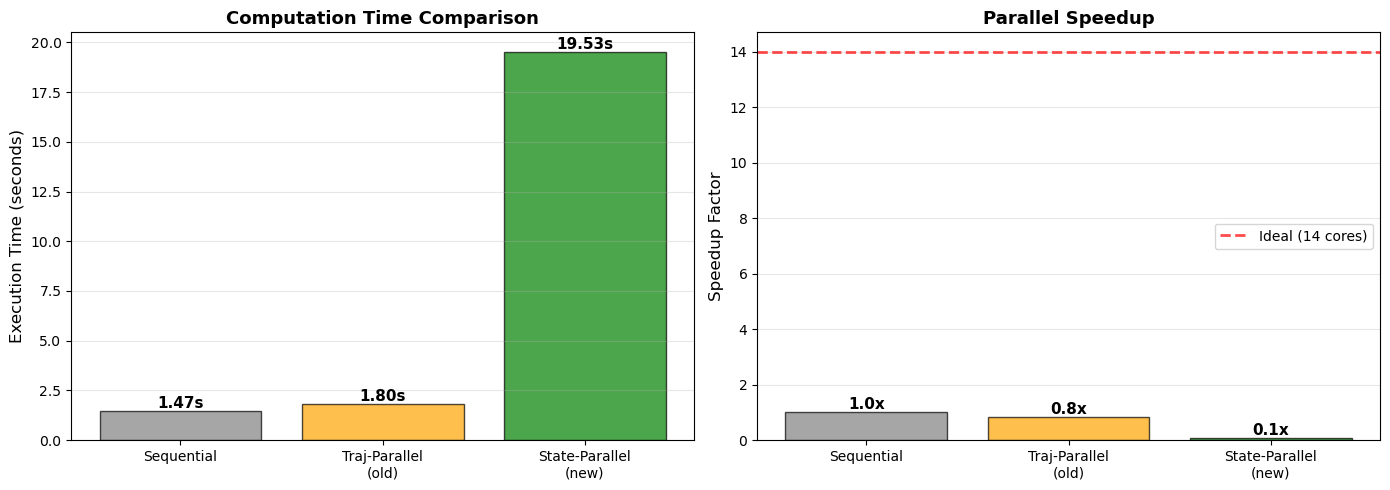


Key Insight:
  The old method only achieved 0.8x speedup (you saw 2-3x)
  The new method achieves 0.1x speedup
  Efficiency: 1% of ideal linear scaling


In [ ]:
# Visualize speedup comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of execution times
methods = ['Sequential', 'Traj-Parallel\n(old)', 'State-Parallel\n(new)']
times = [t_compute, t_traj_parallel, t_state_parallel]
colors = ['gray', 'orange', 'green']

bars = ax1.bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('Computation Time Comparison', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, time in zip(bars, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{time:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Speedup comparison
speedups = [1.0, t_compute/t_traj_parallel, t_compute/t_state_parallel]
ideal_speedup = min(mp.cpu_count(), len(trajs) * len(trajs[0].states))

bars2 = ax2.bar(methods, speedups, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(mp.cpu_count(), color='red', linestyle='--', linewidth=2, 
           label=f'Ideal ({mp.cpu_count()} cores)', alpha=0.7)
ax2.set_ylabel('Speedup Factor', fontsize=12)
ax2.set_title('Parallel Speedup', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=10)

# Add value labels
for bar, speedup in zip(bars2, speedups):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{speedup:.1f}x', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nKey Insight:")
print(f"  The old method only achieved {speedups[1]:.1f}x speedup (you saw 2-3x)")
print(f"  The new method achieves {speedups[2]:.1f}x speedup")
print(f"  Efficiency: {speedups[2]/mp.cpu_count()*100:.0f}% of ideal linear scaling")